# LSTM vs Prophet for Time Series Forecasting (AAPL Stock)

This Jupyter Notebook implements and compares two time series forecasting models:

1. **LSTM (Long Short-Term Memory) neural network** (deep learning)
2. **Prophet** (classical time series model)

Dataset: Daily closing prices of **Apple (AAPL)** downloaded from Yahoo Finance.

> Run the cells from top to bottom. If you get an error about a missing package, scroll to the **Install dependencies** cell and run it first.


In [ ]:
# OPTIONAL: Install dependencies (run once)
# If you already installed these packages in your environment, you can skip this cell.

# !pip install torch pandas numpy matplotlib scikit-learn yfinance prophet


In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import yfinance as yf

# Prophet import: works for the 'prophet' package.
# If you installed 'fbprophet' instead, change to: from fbprophet import Prophet
from prophet import Prophet

plt.rcParams['figure.figsize'] = (10, 4)

## Configuration

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "start_date": "2015-01-01",
    "end_date": "2024-01-01",
    # LSTM hyperparameters
    "seq_len": 60,
    "input_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.2,
    "batch_size": 64,
    "num_epochs": 20,
    "learning_rate": 0.001,
    # Train/test split
    "train_ratio": 0.8,
    # Cross-validation
    "cv_folds": 3,
    # Paths
    "plots_dir": "plots",
    "data_dir": "data"
}

os.makedirs(CONFIG["plots_dir"], exist_ok=True)
os.makedirs(CONFIG["data_dir"], exist_ok=True)

## Utility functions

In [3]:
def download_data(ticker, start, end, data_dir):
    """Download AAPL closing prices from Yahoo Finance."""
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].dropna()
    path = os.path.join(data_dir, f"{ticker}_close.csv")
    df.to_csv(path)
    print(f"Saved data to {path}")
    return df


def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)


def train_val_test_split(X, y, train_ratio=0.8):
    split_idx = int(len(X) * train_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test


def create_dataloaders(X_train, y_train, batch_size):
    dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


def plot_forecast(true, pred, title):
    plt.figure()
    plt.plot(true, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

## LSTM model

In [4]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out


def train_lstm(model, train_loader, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


def lstm_forecast(model, X_test):
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_test, dtype=torch.float32))
    return preds.numpy()

## Cross-validation and Prophet helpers

In [15]:
def time_series_cv_lstm(scaled_series, seq_len, cfg):
    folds = cfg['cv_folds']
    n = len(scaled_series)
    metrics = []
    print("\n[CV] Time-series cross-validation (LSTM)")
    for fold in range(1, folds + 1):
        split = int(n * (0.5 + 0.1 * fold))
        if split >= n - 30:
            break
        train_series = scaled_series[:split]
        test_series = scaled_series[split-seq_len:split+30]

        X_train, y_train = create_sequences(train_series, seq_len)
        X_test, y_test = create_sequences(test_series, seq_len)

        train_loader = create_dataloaders(X_train, y_train, cfg['batch_size'])

        model = LSTMForecaster(
            input_size=cfg['input_size'],
            hidden_size=cfg['hidden_size'],
            num_layers=cfg['num_layers'],
            dropout=cfg['dropout'],
        )

        train_lstm(model, train_loader, num_epochs=5, lr=cfg['learning_rate'])
        preds = lstm_forecast(model, X_test)
        mae, rmse = compute_metrics(y_test, preds)
        metrics.append((mae, rmse))
        print(f"Fold {fold}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    return metrics


def prophet_forecast(close_df, train_ratio):
    """
    Build a clean Prophet dataframe (ds, y) from close_df and run Prophet.
    Works even if 'Close' comes from a MultiIndex / 2D structure.
    """

    # 1️⃣ Get a 1-D close price series
    if isinstance(close_df, pd.DataFrame):
        if 'Close' in close_df.columns:
            close_col = close_df['Close']

            # If this is still a DataFrame (e.g. MultiIndex), take first column
            if isinstance(close_col, pd.DataFrame):
                close_series = close_col.iloc[:, 0]
            else:
                close_series = close_col
        else:
            # Fallback: take the first column
            close_series = close_df.iloc[:, 0]
    else:
        # Already a Series-like
        close_series = close_df

    # Ensure 1-D numeric series
    close_series = pd.to_numeric(close_series.squeeze(), errors='coerce')
    close_series = close_series.dropna()

    # 2️⃣ Build Prophet-style dataframe: ds (date), y (value)
    df_prophet = close_series.reset_index()
    df_prophet.columns = ['ds', 'y']
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
    df_prophet = df_prophet.dropna(subset=['y'])

    # 3️⃣ Train/test split
    split_idx = int(len(df_prophet) * train_ratio)
    train_df = df_prophet.iloc[:split_idx].copy()
    test_df  = df_prophet.iloc[split_idx:].copy()

    # 4️⃣ Fit Prophet
    m = Prophet(daily_seasonality=True)
    m.fit(train_df)

    # 5️⃣ Forecast into the future (same length as test set)
    future = m.make_future_dataframe(periods=len(test_df))
    forecast = m.predict(future)

    # Align predictions with test part
    pred = forecast.iloc[split_idx:]['yhat'].values
    true = test_df['y'].values

    return true, pred, forecast, df_prophet


## Download and preprocess data

In [11]:
cfg = CONFIG

close_df = download_data(cfg['ticker'], cfg['start_date'], cfg['end_date'], cfg['data_dir'])
values = close_df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

seq_len = cfg['seq_len']
X, y = create_sequences(scaled, seq_len)
X_train, X_test, y_train, y_test = train_val_test_split(X, y, cfg['train_ratio'])

print('Total samples:', len(X))
print('Train samples:', len(X_train))
print('Test samples:', len(X_test))

C:\Users\rohit\AppData\Local\Temp\ipykernel_13308\3229885966.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Saved data to data\AAPL_close.csv
Total samples: 2204
Train samples: 1763
Test samples: 441


## Train LSTM and evaluate

Epoch 1/20, Loss: 0.073543
Epoch 2/20, Loss: 0.018020
Epoch 3/20, Loss: 0.001176
Epoch 4/20, Loss: 0.000668
Epoch 5/20, Loss: 0.000668
Epoch 6/20, Loss: 0.000595
Epoch 7/20, Loss: 0.000601
Epoch 8/20, Loss: 0.000553
Epoch 9/20, Loss: 0.000502
Epoch 10/20, Loss: 0.000544
Epoch 11/20, Loss: 0.000588
Epoch 12/20, Loss: 0.000662
Epoch 13/20, Loss: 0.000538
Epoch 14/20, Loss: 0.000469
Epoch 15/20, Loss: 0.000507
Epoch 16/20, Loss: 0.000447
Epoch 17/20, Loss: 0.000444
Epoch 18/20, Loss: 0.000402
Epoch 19/20, Loss: 0.000400
Epoch 20/20, Loss: 0.000399

[LSTM] Test MAE: 4.7197, RMSE: 5.8718


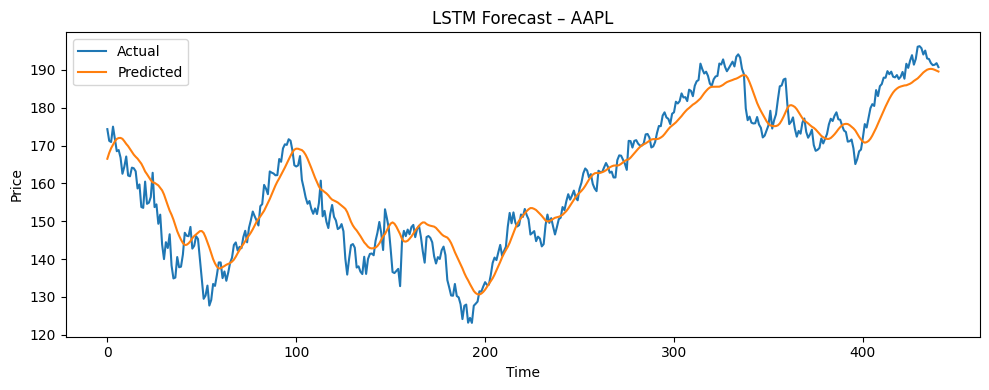

In [12]:
train_loader = create_dataloaders(X_train, y_train, cfg['batch_size'])

lstm_model = LSTMForecaster(
    input_size=cfg['input_size'],
    hidden_size=cfg['hidden_size'],
    num_layers=cfg['num_layers'],
    dropout=cfg['dropout']
)

train_lstm(lstm_model, train_loader, cfg['num_epochs'], cfg['learning_rate'])

# Predict
lstm_preds_scaled = lstm_forecast(lstm_model, X_test)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)
y_test_inv = scaler.inverse_transform(y_test)

lstm_mae, lstm_rmse = compute_metrics(y_test_inv, lstm_preds)
print(f"\n[LSTM] Test MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

plot_forecast(y_test_inv, lstm_preds, f"LSTM Forecast – {cfg['ticker']}")

## LSTM Time-series cross-validation

In [13]:
cv_metrics = time_series_cv_lstm(scaled, seq_len, cfg)
print("\nCross-validation fold metrics (MAE, RMSE):", cv_metrics)


[CV] Time-series cross-validation (LSTM)
Epoch 1/5, Loss: 0.007554
Epoch 2/5, Loss: 0.005698
Epoch 3/5, Loss: 0.002293
Epoch 4/5, Loss: 0.000514
Epoch 5/5, Loss: 0.000188
Fold 1: MAE=0.0061, RMSE=0.0085
Epoch 1/5, Loss: 0.034252
Epoch 2/5, Loss: 0.013894
Epoch 3/5, Loss: 0.001877
Epoch 4/5, Loss: 0.000635
Epoch 5/5, Loss: 0.000412
Fold 2: MAE=0.0179, RMSE=0.0209
Epoch 1/5, Loss: 0.076982
Epoch 2/5, Loss: 0.014617
Epoch 3/5, Loss: 0.001510
Epoch 4/5, Loss: 0.000718
Epoch 5/5, Loss: 0.000579
Fold 3: MAE=0.0355, RMSE=0.0450

Cross-validation fold metrics (MAE, RMSE): [(0.0060548179844768365, 0.00854738348625424), (0.01794631345616541, 0.02085650618003761), (0.035496748312408816, 0.04504643405123917)]


## Prophet model training and evaluation

01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:28 - cmdstanpy - INFO - Chain [1] done processing


[Prophet] Test MAE: 27.2383, RMSE: 30.3922


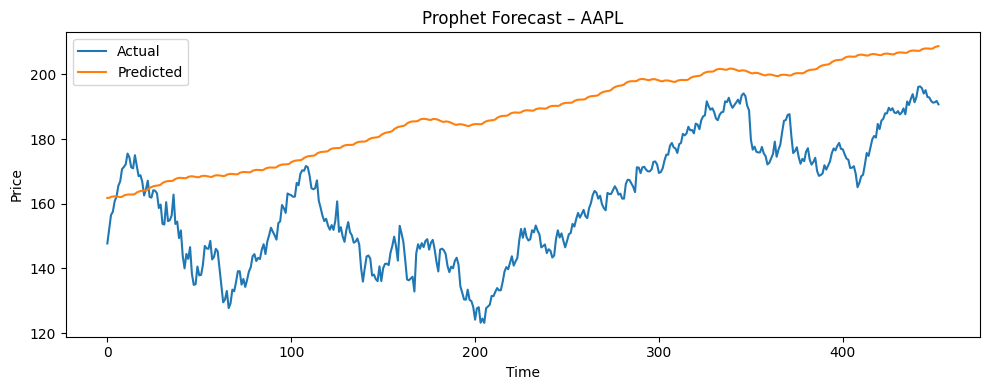

In [16]:
true_prophet, pred_prophet, forecast, df_prophet = prophet_forecast(close_df, cfg['train_ratio'])

prophet_mae, prophet_rmse = compute_metrics(true_prophet, pred_prophet)
print(f"[Prophet] Test MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}")

plot_forecast(true_prophet, pred_prophet, f"Prophet Forecast – {cfg['ticker']}")


## Final comparison

In [17]:
print("===== Final Model Comparison =====")
print(f"LSTM    → MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print(f"Prophet → MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}")

===== Final Model Comparison =====
LSTM    → MAE: 4.7197, RMSE: 5.8718
Prophet → MAE: 27.2383, RMSE: 30.3922
